# Multibinner 

The problem I want to solve is:


> I have a huge `pandas.DataFrame` and I want to rebin some columns and get the oupt of custom function on those bins


The Multibinner module accept in input:

- a `pandas.DataFrame` with `columns`
- bins definition on some columns
- the functions I want to calculate on the bins and on which columns

The output is a shorted `pandas.DataFrame` called `multibinner.MBDataFrame` with multindex, addressing which row goes in which bin.

There are also two useful functions:

- 'multibinner.col_df_to_array' to get an actual numpy array of a single columns
- 'multibinner.all_df_to_array' a dictionary of all the columns -> numpy arrays .

In [129]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import collections
import multibinner as mb

# Dataset definition

The `irisdf` shape is (150, 4), the bins below are defined on the columns:

- `sepal_length` : 10 bins 
- `sepal_width` : 8 bins 

That defines a 10x8 array, each bins containig a variable number of data point from the original DataFrame.

Passing a dictionary of function_names -> function reference we get as ouput the functions calculated on each bin, on the the output columns requested.

For example, here we have:

- `functions` : `{'elements' : len ,'average' : np.average}`
- `output columns` = `petal_length`,`petal_width`

The output columns will be :

- `petal_length` : first columns in output + all the functions 
    - `petal_length_average`
    - `petal_length_elements`
- `petal_width` : second columns in output + all the functions 
    - `petal_width_average`
    - `petal_width_elements`
- central bin of each output row (could be switched off):
    - `sepal_length`
    - `sepal_width`


In [130]:
from sklearn import datasets
iris = datasets.load_iris()
irisdf = pd.DataFrame(iris.data,columns=iris.feature_names)
irisdf.columns = ['_'.join(i.split()[0:2]) for i in irisdf.columns]

In [131]:
irisdf.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [132]:
# Let's multibinning!

# functions we want to apply on the data in a single multidimensional bin:
aggregated_functions = {'elements' : len ,'average' : np.average}

# the columns we want to have in output:
out_columns = ['petal_length','petal_width']

# define the bins for sepal_length
sepal_length_bins = { 'start'  : 4  , 'stop'   : 8, 'n_bins' : 10}
# conformt function generating the bins for you
sepal_length_bins = mb.bingenerator(sepal_length_bins)

# again
sepal_width_bins = { 'start'  : 1  , 'stop'   : 5, 'n_bins' : 8 }
sepal_width_bins = mb.bingenerator(sepal_width_bins)

# use the dataframe column name as key this links the definition to the columns
group_variables = collections.OrderedDict([
                    ('sepal_length',sepal_length_bins),
                    ('sepal_width',sepal_width_bins)
                    ])
# I use OrderedDict to have fixed order, a normal dict is fine too.

print 20*'='
for key,val in group_variables.iteritems():
    print key+' :'
    for sub_key,sub_val in val.iteritems():
        print '{:>15s}: {}'.format(sub_key,sub_val)
    print 20*'='

# apply aggregated_functions on the dataframe and get the out_columns

# that is the object colelcting all the data that define the multi binning
mbdf =  mb.MultiBinnedDataFrame(binstocolumns = False,
                                dataframe = irisdf,
                                group_variables = group_variables,
                                aggregated_functions = aggregated_functions,
                                out_columns = out_columns)

sepal_length :
         n_bins: 10
    bins_center: [ 4.2  4.6  5.   5.4  5.8  6.2  6.6  7.   7.4  7.8]
           stop: 8
          start: 4
       size_bin: 0.4
        n_edges: 11
           bins: [ 4.   4.4  4.8  5.2  5.6  6.   6.4  6.8  7.2  7.6  8. ]
sepal_width :
         n_bins: 8
    bins_center: [ 1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75]
           stop: 5
          start: 1
       size_bin: 0.5
        n_edges: 9
           bins: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5. ]


In [133]:
mbdf.MBDataFrame.head()

petal_length_average  \
sepal_length_binned sepal_width_binned                         
0                   4                                    1.1   
1                   2                                    1.3   
                    3                                    1.4   
                    4                                    1.4   
                    5                                    1.0   

                                        petal_length_elements  \
sepal_length_binned sepal_width_binned                          
0                   4                                       1   
1                   2                                       1   
                    3                                       1   
                    4                                       7   
                    5                                       1   

                                        petal_width_average  \
sepal_length_binned sepal_width_binned                        
0                   4                              0.100000   
1                   2                              0.300000   
                    3                              0.200000   
                    4                              0.214286   
                    5                              0.200000   

                                        petal_width_elements  
sepal_length_binned sepal_width_binned                        
0                   4                                      1  
1                   2                                      1  
                    3                                      1  
                    4                                      7  
                    5                                      1

## Define fucntion on specific columns

The standard behaviour is to calculate all the passed function on all the columns requested for output.
If we want different fucntions on different columns it is easy, just define a dictionary containig 

`DataFrame columns` -> `functions`

the latter could a dictionary `function_names` -> `function reference` too, like in the definition before.

Behind the scenes, the method `multibinner.multibin` checks if all keys in the passed dictionary in are in the columns of the input DataFrame:

    set(aggregated_functions.keys()) <= set(DataFrame.columns)

One could easily define his own functions and the name to identify it , see below. 

In [134]:
# Define a custom functions to get the first element per group,
# we are working on DataFrames after all
first_func = lambda x: x.iloc[0]

aggregated_functions = {
    'petal_length' : {'average' : np.average, 'first' : first_func},
    'petal_width'  : {'elements' : len ,'average' : np.average},    
    }

mbdf =  mb.MultiBinnedDataFrame(binstocolumns = True,
                                dataframe = irisdf,
                                group_variables = group_variables,
                                aggregated_functions = aggregated_functions,
                                out_columns = out_columns)

In [135]:
mbdf.MBDataFrame.head()

petal_width_average  \
sepal_length_binned sepal_width_binned                        
0                   4                              0.100000   
1                   2                              0.300000   
                    3                              0.200000   
                    4                              0.214286   
                    5                              0.200000   

                                        petal_width_elements  \
sepal_length_binned sepal_width_binned                         
0                   4                                      1   
1                   2                                      1   
                    3                                      1   
                    4                                      7   
                    5                                      1   

                                        petal_length_average  \
sepal_length_binned sepal_width_binned                         
0                   4                                    1.1   
1                   2                                    1.3   
                    3                                    1.4   
                    4                                    1.4   
                    5                                    1.0   

                                        petal_length_first  sepal_length  \
sepal_length_binned sepal_width_binned                                     
0                   4                                  1.1           4.2   
1                   2                                  1.3           4.6   
                    3                                  1.4           4.6   
                    4                                  1.3           4.6   
                    5                                  1.0           4.6   

                                        sepal_width  
sepal_length_binned sepal_width_binned               
0                   4                          3.25  
1                   2                          2.25  
                    3                          2.75  
                    4                          3.25  
                    5                          3.75

In [136]:
# reconstruct the multidimensional array defined by group_variables
outstring = []

for key,val in mbdf.group_variables.iteritems():
    outstring.append('{} bins ({})'.format(val['n_bins'],key))

key = 'petal_width_elements'

print '{} array = {}'.format(key,' x '.join(outstring))
print 
print mbdf.col_df_to_array(key)

petal_width_elements array = 10 bins (sepal_length) x 8 bins (sepal_width)

[[ nan  nan  nan  nan   1.  nan  nan  nan]
 [ nan  nan   1.   1.   7.   1.  nan  nan]
 [ nan  nan   3.   2.  16.   9.  nan  nan]
 [ nan  nan   3.   3.   4.   6.   2.  nan]
 [ nan  nan  nan  15.   6.   1.   2.  nan]
 [ nan  nan   4.  13.   8.  nan  nan  nan]
 [ nan  nan  nan   8.  17.  nan  nan  nan]
 [ nan  nan  nan  nan   6.  nan  nan  nan]
 [ nan  nan  nan   2.   2.   1.  nan  nan]
 [ nan  nan  nan   2.   2.   2.  nan  nan]]


## Visualization and wrap up

Now the visual part. 

The question is:

which is :
- the number of element per bin
- the petal_width_average per bin

if we rebin the irisdf on 

- sepal_length_bins = { 'start'  : 4  , 'stop'   : 8, 'n_bins' : 10}
- sepal_width_bins = { 'start'  : 1  , 'stop'   : 5, 'n_bins' : 8 }
?


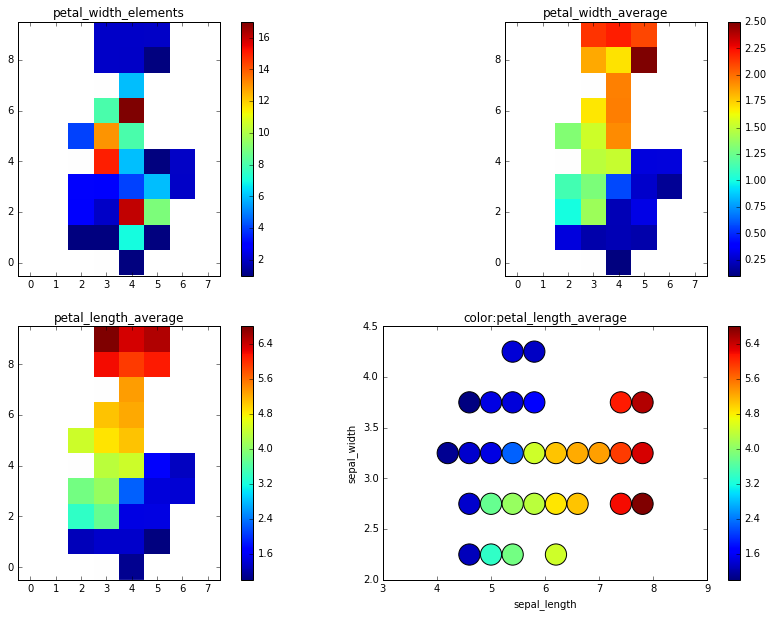

In [137]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=[16,10], ncols=2, nrows=2)

cm = plt.get_cmap('jet')

key = 'petal_width_elements'
imgplot = ax1.imshow(mbdf.col_df_to_array(key), cmap = cm, 
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax1)
ax1.set_title(key)
ax1.grid(False) 

key = 'petal_width_average'
imgplot = ax2.imshow(mbdf.col_df_to_array(key), cmap = cm,
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax2)
ax2.set_title(key)
ax2.grid(False) 

key = 'petal_length_average'
imgplot = ax3.imshow(mbdf.col_df_to_array(key), cmap = cm, 
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax3)
ax3.set_title(key)
ax3.grid(False) 

# leverage pandas.DataFrame plot methods
key = 'petal_length_average'
scatterplot = mbdf.MBDataFrame.plot(kind='scatter', x='sepal_length', y='sepal_width',
                      c = mbdf.MBDataFrame[key],s = 450, ax=ax4, cmap = cm)
ax4.set_title('color:{}'.format(key));

# We want more bins!

Here you are!

In [138]:
# define the bins for sepal_length
sepal_length_bins = { 'start'  : 4  , 'stop'   : 8, 'n_bins' : 30}

sepal_length_bins = mb.bingenerator(sepal_length_bins)

sepal_width_bins = { 'start'  : 1  , 'stop'   : 5, 'n_bins' : 25}

sepal_width_bins = mb.bingenerator(sepal_width_bins)

# use the dataframe column name as key this links the definition to the columns
group_variables = collections.OrderedDict([
                    ('sepal_length',sepal_length_bins),
                    ('sepal_width',sepal_width_bins)
                    ])

# that is the object colelcting all the data that define the multi binning
mbdf =  mb.MultiBinnedDataFrame(binstocolumns = True,
                                dataframe = irisdf,
                                group_variables = group_variables,
                                aggregated_functions = aggregated_functions,
                                out_columns = out_columns)

print 'Output dataframe number of bins: {} '.format(mbdf.col_df_to_array(mbdf.MBDataFrame.columns[0]).size)
print 'Output dataframe number of bins with actual data: {} '.format(mbdf.MBDataFrame.shape[0])
print 'It is completaly redundant, but it works.'

Output dataframe number of bins: 750 
Output dataframe number of bins with actual data: 89 
It is completaly redundant, but it works.


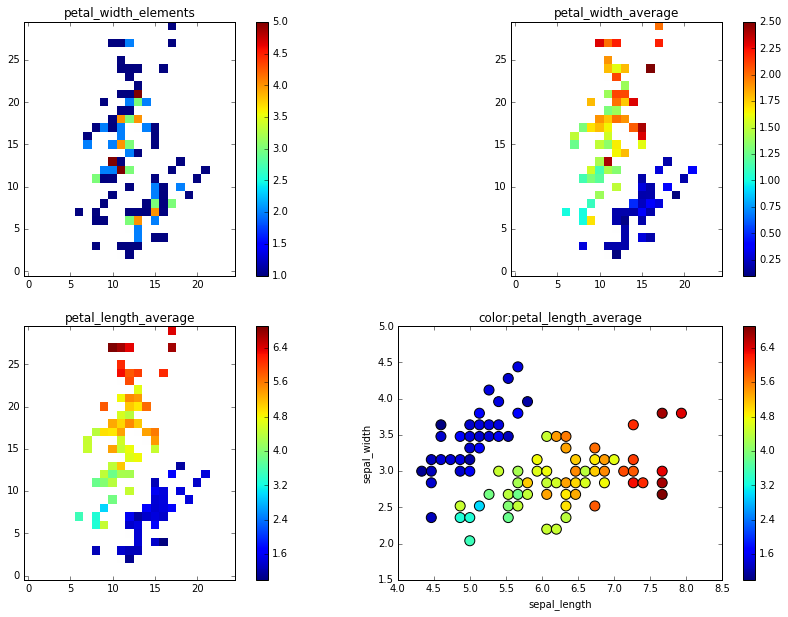

In [139]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=[16,10], ncols=2, nrows=2)

cm = plt.get_cmap('jet')

key = 'petal_width_elements'
imgplot = ax1.imshow(mbdf.col_df_to_array(key), cmap = cm, 
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax1)
ax1.set_title(key)
ax1.grid(False) 

key = 'petal_width_average'
imgplot = ax2.imshow(mbdf.col_df_to_array(key), cmap = cm,
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax2)
ax2.set_title(key)
ax2.grid(False) 

key = 'petal_length_average'
imgplot = ax3.imshow(mbdf.col_df_to_array(key), cmap = cm, 
                     interpolation='none',origin='lower')
plt.colorbar(imgplot, orientation='vertical', ax = ax3)
ax3.set_title(key)
ax3.grid(False) 

# leverage pandas.DataFrame plot methods
key = 'petal_length_average'
scatterplot = mbdf.MBDataFrame.plot(kind='scatter', x='sepal_length', y='sepal_width',
                      c = mbdf.MBDataFrame[key],s = 100, ax=ax4, cmap = cm)
ax4.set_title('color:{}'.format(key));